
## makin a gan

The followig is an architecture of a cycle gan, here am using a data set of handwritten images 28x28 and trying to generate A's from B's and the other way around,the scope of these are far more than this but as i was starting it out i thought i'd approach it slowly ,also took inspirations from lotta other kaggle notebooks too, and i'll be trying to dig deep and do more better stuff from this sort of an architecture.
so, feel free to discuss anything related ,and if you got any ideas or advices please share.
enjoy..

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader 

In [10]:
import warnings
warnings.simplefilter('ignore')
%config Complete.use_jedi=False

In [11]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:

#loader function
class data_load:
    def __init__(self,url,mode='train',trans=None):
        data=np.loadtxt(url,delimiter=',',skiprows=1,dtype=np.float32)
        A=data[:,1:][data[:,0]==0]
        B=data[:,1:][data[:,0]==1]
        A=A.reshape(A.shape[0],28,28)/255
        B=B.reshape(B.shape[0],28,28)/255
        
        if A.shape > B.shape:
            limit= B.shape[0]
        else:
            limit=A.shape[0]
        index=int(math.floor(limit*(4/5)))
        if mode=='train': 
            self.A=A[:index,:]
            self.B=B[:index,:]
        elif mode=='test':
            self.A=A[index:limit,:]
            self.B=B[index:limit,:]
        
        
        self.len=self.A.shape[0]    
        self.trans=trans
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,index):
        A=self.A[index]
        B=self.B[index]
        if self.trans is not None:
            A=self.trans(A)
            B=self.trans(B)
        return A,B

In [13]:
##loading the data and apropriately transforming

transformations=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(0.5,0.5)
                                   ])
train_data=DataLoader(
data_load("../input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv",
mode='train',
trans=transformations),
batch_size=20,
shuffle=True)

test_data=DataLoader(
data_load("../input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv",
mode='test',
trans=transformations),
batch_size=20,
shuffle=False)

In [14]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.main=nn.Sequential(
            *self.block(in_channels,64,norm=False), #28-14
            *self.block(64,128,norm=True),             #141-7
            nn.ZeroPad2d((1,0,1,0)),                  #7-8
            nn.Conv2d(128,1,4,1,1))             #8-7  fianl shape (batch_size x1x7x7)
                                                                 
                
    @staticmethod    
    def block(in_channels,out_channels,norm=False):
        block=[nn.Conv2d(in_channels,out_channels,4,2,1)]
        if norm:
            block.append(nn.InstanceNorm2d(out_channels))
        block.append(nn.LeakyReLU(0.2,inplace=True))
        return block
        
    def forward(self,x):
        return self.main(x)

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [16]:
#generator

class Generator(nn.Module):

    def __init__(self,in_channels):
        super().__init__()
        #initial convolution
        self.conv=nn.Sequential(nn.ReflectionPad2d(in_channels),
                               nn.Conv2d(in_channels,64,(2*in_channels)+1),
                               nn.InstanceNorm2d(64),
                               nn.ReLU(inplace=True) #final image of same size,channel_size=64
        )
        
        #downsample to 7x7, chanel_size to increase by doble evry time 
        self.down=nn.Sequential(*self.downer(64,128),
                                *self.downer(128,256)
                                
        )
        #does't change the size of the image at all
        self.trans = [ResidualBlock(256) for _ in range(5)]
        self.trans = nn.Sequential(*self.trans)
        
        #upsampling to original image size
        self.up = nn.Sequential(*self.upper(256,128),
                                *self.upper(128,64)
                               
                               )
        
        self.out = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,1, 2*in_channels+1),
            nn.Tanh()
        )
    
   
    
    @staticmethod
    def downer(in_channels,out_channels):
        block=[nn.Conv2d(in_channels,out_channels,3,2,1),
               nn.InstanceNorm2d(out_channels),
               nn.ReLU(inplace=True)]
        return block
    
    @staticmethod    
    def upper(in_channels,out_channels):
        block=[nn.Upsample(scale_factor=2),
               nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
               nn.InstanceNorm2d(out_channels),
               nn.ReLU(inplace=True)
              ]
        return block
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x
        

In [ ]:
from torchvision.utils import make_grid

def plot(real_a,real_b):
    """plots the generated images

    Args:
        real_a (tensor): real image a
        real_b (tensor): real image b
    """
    real_a=real_a.to(device)
    real_b=real_b.to(device)
    G_ab.eval()
    G_ba.eval()
    with torch.no_grad():
        fake_a=G_ba(real_b[:5]).detach()
        fake_b=G_ab(real_a[:5]).detach()

        f_a=make_grid(fake_a)
        f_b=make_grid(fake_b)
        grid=torch.cat((f_a,f_b),1).to('cpu')
        grid=transforms.functional.to_pil_image(grid)
#         grid=grid
        plt.figure(figsize=(8,8))
        plt.matshow(grid)
        plt.axis('off')
        plt.show()


            epoch = 10/60
            gan_loss = 1.4407706260681152
            subsidiaries:
            id=0.12034732848405838 , gan=0.498893678188324 , cy=0.03401403874158859
 
            total_d_loss = 0.2111167311668396
            subsidiaries:
            da=0.1988537758588791 , db=0.2233797013759613
            


<Figure size 576x576 with 0 Axes>

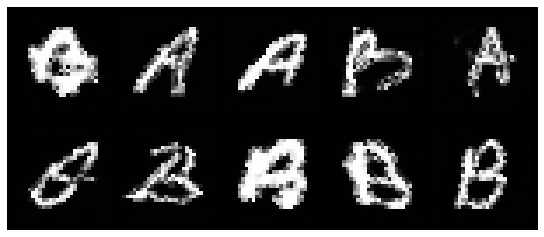


            epoch = 20/60
            gan_loss = 1.5046230554580688
            subsidiaries:
            id=0.14152118563652039 , gan=0.49965938925743103 , cy=0.02973577007651329
 
            total_d_loss = 0.1390264630317688
            subsidiaries:
            da=0.15543538331985474 , db=0.12261754274368286
            


<Figure size 576x576 with 0 Axes>

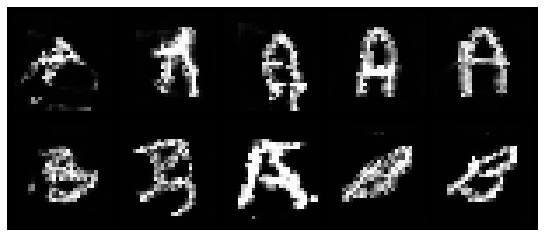


            epoch = 30/60
            gan_loss = 1.4594873189926147
            subsidiaries:
            id=0.13217005133628845 , gan=0.5372283458709717 , cy=0.026140864938497543
 
            total_d_loss = 0.16843968629837036
            subsidiaries:
            da=0.17409077286720276 , db=0.16278859972953796
            


<Figure size 576x576 with 0 Axes>

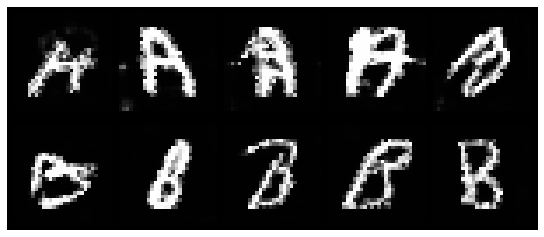

In [ ]:
# criterions
criterion_gan=nn.MSELoss()
criterion_cycle=nn.L1Loss()
criterion_identity=nn.L1Loss()

#changing to device
criterion_gan.to(device)
criterion_cycle.to(device)
criterion_identity.to(device)

#model
G_ab=Generator(1)
G_ba=Generator(1)
D_a=Discriminator(1)
D_b=Discriminator(1)

#changing them to device
G_ab=G_ab.to(device)
G_ba=G_ba.to(device)
D_a=D_a.to(device)
D_b=D_b.to(device)


#optimizer
import itertools
lr = 0.0005
b1 = 0.5
b2 = 0.996

optim_G=optim.Adam(itertools.chain(G_ab.parameters(),G_ba.parameters()),lr=lr,betas=(b1,b2))
optim_Da=optim.Adam(D_a.parameters(),lr=lr,betas=(b1,b2))
optim_Db=optim.Adam(D_b.parameters(),lr=lr,betas=(b1,b2))


#lr scheduler
epochs = 30
decay_epoch = 20
lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(epochs-decay_epoch)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optim_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optim_Da, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optim_Db, lr_lambda=lambda_func)


for epoch in range(epochs):
    for i,(a,b) in enumerate(train_data):
        a,b=a.to(device),b.to(device)
        shape=[int(a.size(0)),1,int(a.size(2)/4),int(a.size(3)/4)]
        real_label=torch.ones(shape,device=device)
        fake_label=torch.zeros(shape,device=device)
        
        G_ab.train()
        G_ba.train()
        
        fake_b=G_ab(a)
        fake_a=G_ba(b)
        
        #loss beetween in _im and out_im
        id_1=criterion_identity(fake_b,a)
        id_2=criterion_identity(fake_a,b)
        main_id=(id_1+id_2)/2
        
        #missguiding 
        gan_1=criterion_gan(D_a(fake_a),real_label)
        gan_2=criterion_gan(D_b(fake_b),real_label)
        main_gan=(gan_1+gan_2)/2
        
        
        cy_1=criterion_cycle(G_ba(fake_b),a)
        cy_2=criterion_cycle(G_ab(fake_a),b)
        main_cy=(cy_1+cy_2)/2
        
        gan_loss=5*main_id + main_gan +10*main_cy
        optim_G.zero_grad()
        gan_loss.backward()
        optim_G.step()
        
        #trainnig_D_a
        optim_Da.zero_grad()
        da_1=criterion_gan(D_a(fake_a.detach()),fake_label)
        da_2=criterion_gan(D_a(a),real_label)
        loss_da=(da_1+da_2)/2
        loss_da.backward()
        optim_Da.step()
        #training D_b
        optim_Db.zero_grad()
        db_1=criterion_gan(D_b(fake_b.detach()),fake_label)
        db_2=criterion_gan(D_b(b),real_label)
        loss_db=(db_1+db_2)/2
        loss_db.backward()
        optim_Db.step()
        
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    with torch.no_grad():
        
        if (epoch+1)%10==0:

            loss_d=(loss_da+loss_db)/2
            print(f'''
            epoch = {epoch+1}/{epochs}
            gan_loss = {gan_loss.item()}
            subsidiaries:
            id={main_id.item()} , gan={main_gan.item()} , cy={main_cy.item()}
 
            total_d_loss = {loss_d.item()}
            subsidiaries:
            da={loss_da.item()} , db={loss_db.item()}
            ''')

            a,b=next(iter(train_data))
            plot(a,b)